In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ.drop(columns=["actor"], inplace=True)

from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score
scaler = MinMaxScaler()

X = scaler.fit_transform(quant.values)

scaled_df = pd.DataFrame(scaler.fit_transform(quant), columns=quant.columns)

In [43]:
from sklearn.cluster import KMeans

features = list(quant.columns)
combos = [[col] for col in features]
best_features = []

for i in range(3):
    scores = []
    for feat in combos:
        Y = scaled_df[feat]
        labels = KMeans(n_clusters=4, n_init=5).fit(Y).labels_
        scores.append(silhouette_score(Y, labels))
        # scores.append(np.random.uniform(0,1))
    
    best_score_index = np.argmax(scores)
    best_features.append(features[best_score_index])
    combos = [best_features + [f] for f in features if f not in best_features]
    features.remove(features[best_score_index]) 
    print(f"best silhouette is for {best_features} (S = {scores[best_score_index]})")


best silhouette is for ['sc_max'] (S = 0.6616385483700166)
best silhouette is for ['sc_max', 'sc_kur'] (S = 0.5518581566808639)
best silhouette is for ['sc_max', 'sc_kur', 'stft_kur'] (S = 0.44777244047673764)


<AxesSubplot: xlabel='sc_max', ylabel='sc_kur'>

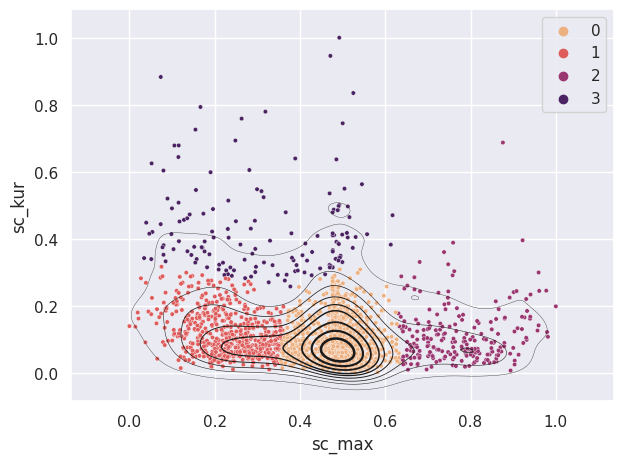

In [44]:
f1, f2 = best_features[:2]
Y = scaled_df[[f1, f2]]
labels = KMeans(n_clusters=4, n_init=20).fit(Y).labels_
sns.scatterplot(data=scaled_df, x=f1, y=f2,s=10, hue=labels, palette="flare")
sns.kdeplot(data=scaled_df, x=f1, y=f2, color="k", linewidths=np.linspace(.5,2,15)**2)

(0.0, 1.0)

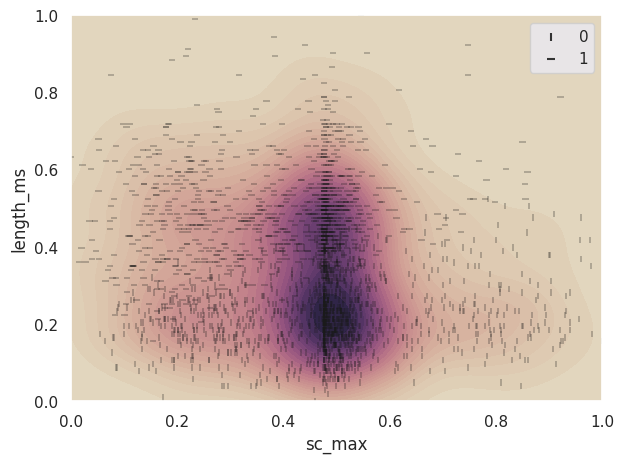

In [45]:
new_df = scaled_df.copy()
new_df.sc_max += np.random.normal(0, 0.05, size=len(quant) )
new_df.length_ms += np.random.normal(0, 0.05, size=len(quant) )
Y = new_df[["sc_max", "length_ms"]]
labels = KMeans(n_clusters=2, n_init=20).fit(Y).labels_
cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
sns.kdeplot(data=new_df, x="sc_max", y="length_ms",fill=True, thresh=0, levels=np.linspace(0,1,30), cmap=cmap, bw_method=.3)
sns.scatterplot(data=scaled_df, x="sc_max", y="length_ms",s=20, color="k", style=labels, markers=["|","_"])
plt.xlim(0,1)
plt.ylim(0,1)